In [115]:
import os 
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt

read_csv_cpp = True #True: process in the c++ libr the same vectors produced with numpy
                    # and processed with pandas.
                    # False: creates internally to c++ random vectors (with same size of)
                    # of those processed with pandas
                    # time to solution faster with False (no csv reading)
                    # time benchmark of the performance is the same with True or False
                    # (valuated only on the computational part, no I/O)

do_mean = 0     # if one want the benchmark to be done on mean
do_var  = 0     # if one want the benchmark to be done on var
do_corr = 1     # if one want the benchmark to be done on corr

compile_cpp = True
N_vect     = 2
n_elements = 10**6
# generate N_vect random vectors
for ii in range(N_vect):
    dummy = np.random.rand(n_elements)
    dummy_df = pd.Series(dummy,name=str(ii))
    if ii == 0:
        vect = dummy_df.copy()
    else:
        vect = pd.concat([vect,dummy_df],axis=1)

In [77]:

if compile_cpp:
    # Windows
    !g++ -std=c++23 -o test.exe main.cpp interface_vectors.cpp kernels.cpp -IC:\Users\Administrator\Libreries\boost_1_89_0 -I.


In [95]:
def write_file(filename, vect):
    X = np.asarray(vect.values, dtype=np.float64)
    nele, nvect = X.shape

    with open(filename, "wb") as f:
        np.array([nele], dtype=np.uint64).tofile(f)
        np.array([nvect], dtype=np.uint64).tofile(f)
        X.tofile(f)   # row-major (C order)
    return

In [108]:
import time
window_size = 100
start_pd = time.perf_counter()

if do_mean==1:
    rolling_mean         = vect.rolling(window=window_size).mean()
if do_var==1:
    rolling_var          = vect.rolling(window=window_size).var()
if do_corr==1:
    rolling_corr         = vect.rolling(window=window_size).corr()

end_pd = time.perf_counter()
print(f"Rolling stats with Pandas: {end_pd - start_pd:.4f} secondi")

N_threads = 4
if (read_csv_cpp):
    write_file("file.bin",vect)
    !.\test.exe path=.\file.bin w={window_size} num_threads={N_threads} do_corr={do_corr} do_mean={do_mean} do_var={do_var} Ntest_speed=5 > stdout
else:
    !.\test.exe n_vect={N_vect} n={vect.shape[0]} w={window_size} num_threads={N_threads}  do_corr={do_corr} do_mean={do_mean} do_var={do_var} Ntest_speed=5 > stdout

df = pd.read_csv("timing.csv", sep=";")  
print("Rolling stats c++ with different methods:\n")
for ii in range(df.shape[0]):
    print("- "+df.loc[ii,"method"] + " time to solution is: "+ str(df.loc[ii,"time"]))


Rolling stats with Pandas: 1.8706 secondi
Rolling stats c++ with different methods:

- parallel vectors input - parallel vector treatment time to solution is: 0.167461
- parallel vectors input - serial vector treatment time to solution is: 0.167841
- serial vectors input - parallel vector treatment time to solution is: 0.173654
- serial vectors input - serial vector treatment time to solution is: 0.392652


### time benchmark - pandas / c++ conclusions:
For two vectors with 10^6 elements the C++ library is at least **10 times** faster when running with parallelism.

Bottlneck of the C++ library is the reading of csv file. To improve the overall C++ one should go in binary. Here the pourpose is to compare the algos and not the full flow that may depends on where the data come from.

### Benchmark of the results

c:\ProgramData\miniconda3\envs\ML_python\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


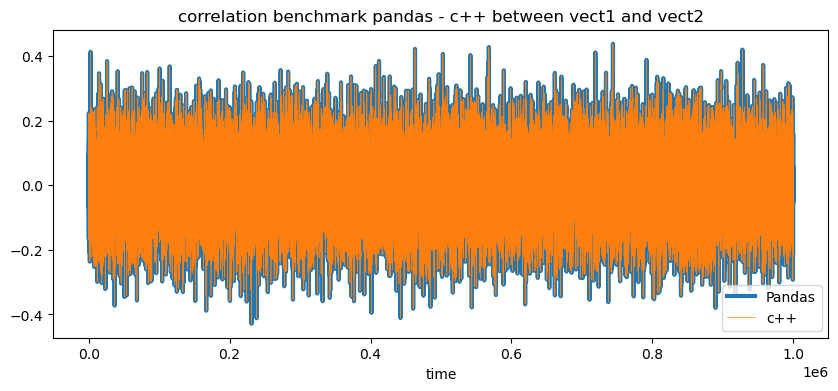

In [114]:
if read_csv_cpp: # it makes sense only if using the same data 
    if do_corr == 1:
        fname = "correlation.bin"
        with open(fname, "rb") as f:
            n_vect  = int(np.fromfile(f, dtype=np.int32, count=1)[0])
            n_vect2 = int(np.fromfile(f, dtype=np.int32, count=1)[0])
            n_el    = int(np.fromfile(f, dtype=np.uint64, count=1)[0])

            assert n_vect == n_vect2

            data = np.fromfile(f, count=n_vect * n_vect * n_el )

        corr = data.reshape((n_vect, n_vect, n_el))

        plt.figure(figsize=(10,4))

        plt.plot(rolling_corr.loc[(slice(window_size-1, None), "0"), str(N_vect-1)].values,linewidth=3.0,label="Pandas")
        plt.plot(corr[0,-1,0:-window_size],linewidth=0.5,label="c++")
        plt.xlabel("time")
        plt.title("correlation benchmark pandas - c++ between vect1 and vect2");
        plt.legend()

    if  do_mean == 1:
        fname = "mean.bin"
        with open(fname, "rb") as f:
            n_vect  = int(np.fromfile(f, dtype=np.int32, count=1)[0])
            n_el    = int(np.fromfile(f, dtype=np.uint64, count=1)[0])
            data    = np.fromfile(f, count=n_vect * n_el )

        mean = data.reshape((n_vect, n_el))

        plt.figure(figsize=(10,4))
        mask_index = rolling_mean.index>=window_size-1
        plt.plot(rolling_mean.loc[mask_index, "0"].values,linewidth=3.0,label="Pandas")
        plt.plot(mean[0,0:-window_size],linewidth=0.5,label="c++")
        plt.xlabel("time")
        plt.title("var benchmark pandas - c++ between vect1 and vect2");
        plt.legend()

    if  do_var == 1:
        fname = "variance.bin"
        with open(fname, "rb") as f:
            n_vect  = int(np.fromfile(f, dtype=np.int32, count=1)[0])
            n_el    = int(np.fromfile(f, dtype=np.uint64, count=1)[0])
            data    = np.fromfile(f, count=n_vect * n_el )

        var = data.reshape((n_vect, n_el))

        plt.figure(figsize=(10,4))
        mask_index = rolling_mean.index>=window_size-1
        plt.plot(rolling_var.loc[mask_index, "0"].values,linewidth=3.0,label="Pandas")
        plt.plot(var[0,0:-window_size],linewidth=0.5,label="c++")
        plt.xlabel("time")
        plt.title("mean benchmark pandas - c++ between vect1 and vect2");
        plt.legend()




### Time-to solution scaling
Some plots to see how the computational time scales when changing several parameters (one at the time):
 - N elements of the vectors
 - N threads
 - rolling window size

In [17]:
import subprocess

def run_benchmark(ranges, N_tot, threads, window, method="length", N_runs=1, verbose=False):
    df_tot = None
    init_threads = threads
    init_N_tot   = N_tot
    init_window  = window
    x=[]
    for jj in ranges:
        
        if method == "length":
            N_tot = init_N_tot * 2**jj  
            title = "scaling of the time to solution varying array length\n time window = {}, N threads = {}".format(window, threads)
            x.append(N_tot)
            xlab = "vectors length"
        elif method == "threads":
            threads = init_threads**jj
            title = "scaling of the time to solution varying N threads\n time window = {}, vectors length = {}".format(window, N_tot)
            x.append(threads)
            xlab = "N threads"

        elif method == "window":
            window = init_window * 2**jj        
            title = "scaling of the time to solution varying rolling window\n N threads = {}, vectors length = {}".format(threads, N_tot)
            x.append(window)
            xlab = "rolling window"

        subprocess.run([r".\test.exe", "n="+str(N_tot), "num_threads="+str(threads), "w="+str(window), "Ntest_speed="+str(N_runs)], check=True)

        if verbose:
            print("iteration with "+method+" = "+ str(x[-1])+" done")
        df = pd.read_csv("timing.csv", sep=";")  
        df = df.rename(columns={"time": str(x[-1])}) 
        if df_tot is None:
            df_tot = df.copy()
        else:
            df_tot = df_tot.merge(df, on="method", how="outer")

    num_cols = df_tot.columns.drop("method")
    
    plt.figure(figsize=(8,3))
    for ii in range(df_tot.shape[0]):
        y = df_tot.loc[ii, num_cols].values
        plt.plot(num_cols, y, marker="o", label=df_tot.loc[ii, "method"])
        plt.yscale("log")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2)
    plt.title(title)
    plt.xlabel(xlab)

iteration with length = 1000 done
iteration with length = 4000 done
iteration with length = 16000 done
iteration with length = 64000 done
iteration with threads = 1 done
iteration with threads = 2 done
iteration with threads = 4 done
iteration with threads = 8 done
iteration with threads = 16 done
iteration with window = 100 done
iteration with window = 200 done
iteration with window = 400 done


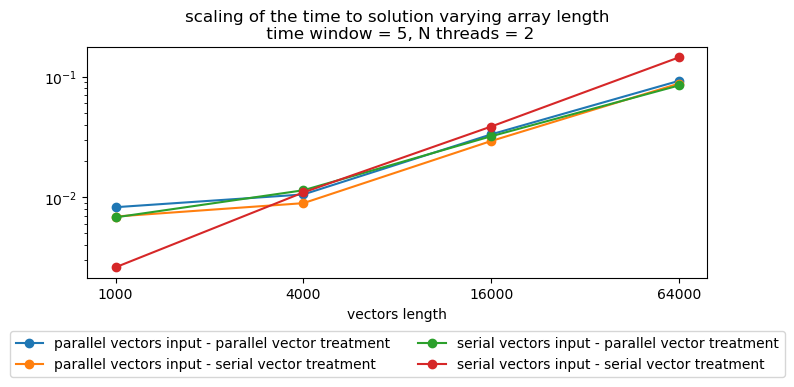

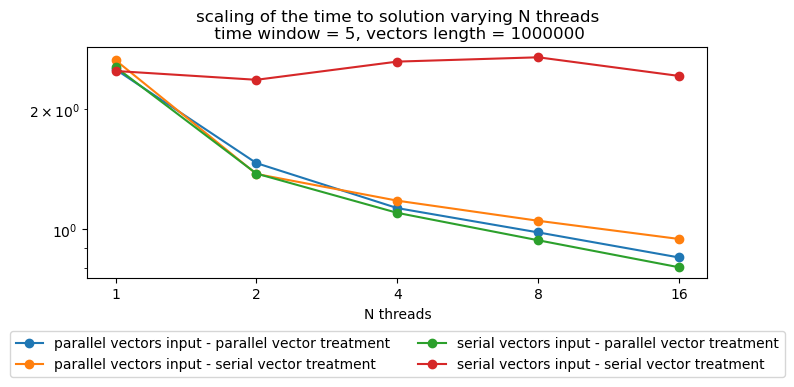

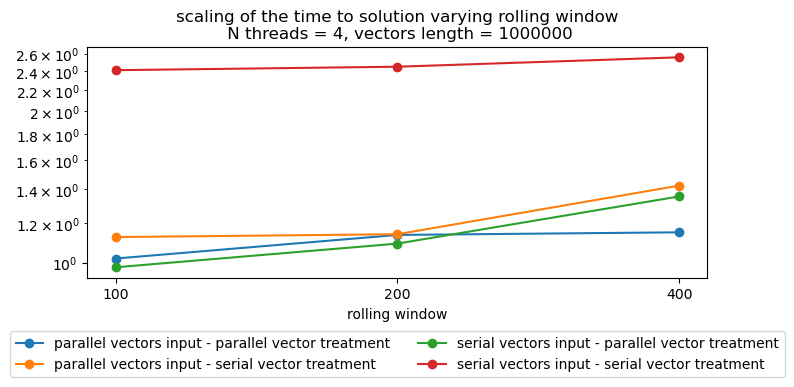

In [19]:
verb = True
Nruns = 5 # the algo is run Nruns times: timing is more stable
run_benchmark(range(0,8,2), 1000, 2, 5, method="length", N_runs=Nruns, verbose=verb)
run_benchmark(range(0,5), 1000000, 2, 5, method="threads", N_runs=Nruns, verbose=verb) # N trades as 2**ii  with ii in range(...)
run_benchmark(range(0,3), 1000000, 4, 100, method="window", N_runs=Nruns, verbose=verb)